#Imports

In [1]:
import pandas as pd
import numpy as np
import os
import math
import librosa

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import keras
from keras import layers, Sequential
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Model and Prediction Process

In [6]:
model_path = os.getcwd()+'/drive/MyDrive/Sub_Data/CNN_model_mfcc13_G.h5'
cnn_model = keras.models.load_model(model_path)
cnn_model

In [7]:
n_mfcc=13
n_fft=2048
num_segments = 10
hop_length = 512
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [8]:
num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
print(f'No of samples per segment: {num_samples_per_segment}')
expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)
print(f'Expected no of mfcc vectors per segment: {expected_num_mfcc_vectors_per_segment}')

No of samples per segment: 66150
Expected no of mfcc vectors per segment: 130


**Loading sample song**

In [9]:
song_path = os.getcwd()+'/drive/MyDrive/Sub_Data/Songs/love_story.wav'

In [10]:
signal, sample_rate = librosa.load(song_path, sr=SAMPLE_RATE)
song_length = int(librosa.get_duration(filename=song_path))
print(song_length)

236


In [11]:
if song_length > 30:
    discarded_song_length = (song_length % 30)
    song_length -= discarded_song_length
    print(f"Song is greater than 30 seconds")
    SAMPLES_PER_SONG = SAMPLE_RATE * song_length
    parts= int(song_length/30)
    SAMPLES_PER_SEGMENT_30 = int(SAMPLES_PER_SONG/(parts))
    flag = 1
    print(f"Song sliced into {str(parts)} parts")
    print(f"Samples per song: {SAMPLES_PER_SONG}")
    print(f'Samples PER 30 SEGMENT {SAMPLES_PER_SEGMENT_30}')
elif song_length ==30:
    parts = 1
    flag = 0
else:
    print("Too short, enter a song of length minimum 30 seconds")
    flag = 2


Song is greater than 30 seconds
Song sliced into 7 parts
Samples per song: 4630500
Samples PER 30 SEGMENT 661500


In [12]:
def generating_headers(n_mfcc=13):
  headers = []
  for i in range(1,n_mfcc+1):
    headers.append(f'mfcc_{i}')
  return headers

In [13]:
headers = generating_headers()
headers

['mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13']

In [14]:
single_file_df = pd.DataFrame()
for i in range(0, parts):
    if flag ==1:
        print(f'Song snipped: {i+1}')
        # calculate start and finish sample for current part
        start30 = SAMPLES_PER_SEGMENT_30  * i
        finish30= start30 + SAMPLES_PER_SEGMENT_30
        y = signal[start30:finish30]
    elif flag == 0:
        print('Song is 30 seconds long so no need for slicing.')
    
    for segment in range(num_segments):
        # calculate start and finish sample for current segment
        start_sample = num_samples_per_segment * segment 
        finish_sample = start_sample + num_samples_per_segment

        #extract mfcc
        mfcc = librosa.feature.mfcc(y[start_sample:finish_sample], sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T
        # print(f'Shape of mfcc: {mfcc.shape}')
        # mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1],1)
        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
            segment_df = pd.DataFrame(data=mfcc,
                                    columns= headers,
                                            index = range(len(mfcc)))
            single_file_df = pd.concat([single_file_df, segment_df],
                                    axis=0,
                                    sort=False,
                                    ignore_index=True)
            
        




Song snipped: 1
Song snipped: 2
Song snipped: 3
Song snipped: 4
Song snipped: 5
Song snipped: 6
Song snipped: 7


**Single segment dataframe**

In [15]:
segment_df

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,-148.176376,58.849495,2.231683,30.156811,5.731663,5.498857,1.786801,-4.123281,-3.815950,1.480081,-6.051296,9.690369,0.997327
1,-149.872635,61.860146,2.299911,33.350506,10.012131,8.513197,-1.911406,-7.383233,-3.873552,0.432916,-10.030327,5.771752,2.207474
2,-160.075821,60.924690,2.296649,29.362411,8.776583,9.735889,-5.213862,-7.864872,-5.764274,-2.250992,-11.839720,2.331911,2.522912
3,-166.390732,60.144241,9.190243,24.105061,3.408327,9.906729,-7.446197,-7.515676,-6.907587,0.833174,-5.457887,2.465569,-0.304948
4,-167.846725,63.226685,5.078386,24.152412,3.763126,8.905701,-5.221114,-12.700048,-11.406059,0.756910,-0.464761,0.727844,-4.665423
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,-213.530746,77.568451,-11.947769,26.175093,-0.389100,20.515320,0.051383,14.321722,5.260984,7.594134,-4.339521,9.086059,-5.130365
126,-206.128571,73.547333,-5.940646,20.333878,-0.418467,24.047176,-0.321561,12.356216,5.765261,8.984378,-1.066398,11.144606,-4.633588
127,-183.503708,47.352364,11.766156,21.078724,-6.373882,32.099030,-4.709827,12.623925,4.735358,16.812737,-2.374120,12.653233,-6.130325
128,-136.275650,41.219353,24.810184,27.256746,-9.594030,16.988823,-11.088366,1.944046,-5.501165,7.407494,-6.402434,11.670574,-9.197866


**Dataframe of the whole song**

In [16]:
single_file_df

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,-899.322937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-899.322937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-899.322937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-899.322937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-899.322937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9095,-213.530746,77.568451,-11.947769,26.175093,-0.389100,20.515320,0.051383,14.321722,5.260984,7.594134,-4.339521,9.086059,-5.130365
9096,-206.128571,73.547333,-5.940646,20.333878,-0.418467,24.047176,-0.321561,12.356216,5.765261,8.984378,-1.066398,11.144606,-4.633588
9097,-183.503708,47.352364,11.766156,21.078724,-6.373882,32.099030,-4.709827,12.623925,4.735358,16.812737,-2.374120,12.653233,-6.130325
9098,-136.275650,41.219353,24.810184,27.256746,-9.594030,16.988823,-11.088366,1.944046,-5.501165,7.407494,-6.402434,11.670574,-9.197866


In [17]:
len(single_file_df)

9100

In [18]:
if flag == 1:
  single_file_df = single_file_df.iloc[390: len(single_file_df) - 390]

In [19]:
single_file_df

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
390,-492.022522,221.990723,-25.822758,-10.503971,-7.760462,-8.072725,-4.100123,6.554296,1.446481,-4.992213,-17.418743,-7.103581,0.893419
391,-498.153259,213.656830,-18.138809,-6.754316,-6.668977,-11.586367,-5.572831,5.633811,-0.183314,-7.040876,-16.573147,-2.192443,2.878886
392,-447.611664,149.532837,19.051647,-10.643509,-6.140965,-7.388492,-10.547832,1.630062,-1.296755,-4.382339,-8.097672,6.077648,-0.580983
393,-397.776825,139.435379,28.204884,-12.444464,-12.812505,-9.201343,-3.790159,1.712969,2.804123,-7.947084,-9.788048,-2.094393,-2.331987
394,-397.969299,147.673340,32.440826,-12.245346,-4.429707,-9.003803,-0.851206,2.222485,3.904117,-13.261947,-6.286728,-5.564908,-3.256240
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8705,-121.508385,69.823273,1.692790,18.495541,-3.527219,6.103481,-8.898420,6.419630,-7.249172,3.644646,-9.598917,-6.091460,-0.703031
8706,-121.956841,68.511856,3.478100,10.045416,-1.325720,6.070758,-8.019709,4.156004,-2.410028,5.412845,-3.695178,-2.010675,-3.994624
8707,-135.210999,70.456909,-4.804649,8.412874,4.696113,6.364796,-5.461402,2.737119,0.942574,8.593540,-1.218001,3.941343,2.900291
8708,-147.101913,67.765923,-5.492129,14.991959,4.004101,7.306721,-4.076278,1.582791,0.951866,8.189951,-4.644315,3.299723,4.754741


In [20]:
song_values= []
for i in range(0,single_file_df.shape[0],130):
    # print(i, i+130)
    # i+1
    # if i>=song_df2.shape[0]+130:
    #     break
    song_values.append(single_file_df.iloc[i:i+130,:])
    i+=1
    if i >=single_file_df.shape[0]+130:
        break

In [21]:
song_values

[         mfcc_1      mfcc_2     mfcc_3  ...    mfcc_11   mfcc_12   mfcc_13
 390 -492.022522  221.990723 -25.822758  ... -17.418743 -7.103581  0.893419
 391 -498.153259  213.656830 -18.138809  ... -16.573147 -2.192443  2.878886
 392 -447.611664  149.532837  19.051647  ...  -8.097672  6.077648 -0.580983
 393 -397.776825  139.435379  28.204884  ...  -9.788048 -2.094393 -2.331987
 394 -397.969299  147.673340  32.440826  ...  -6.286728 -5.564908 -3.256240
 ..          ...         ...        ...  ...        ...       ...       ...
 515 -475.243164  200.763733 -21.028805  ...  -8.404052  3.631967 -1.490010
 516 -495.025330  200.864380 -21.890850  ...  -2.967733 -3.013862  0.579182
 517 -506.314331  202.724945 -25.331005  ...  -7.154740 -4.385885 -3.990628
 518 -498.754547  198.160065 -32.828690  ... -12.863153 -8.701575 -1.627706
 519 -484.096313  199.491882 -34.964577  ... -14.304271 -7.974526  1.305053
 
 [130 rows x 13 columns],
          mfcc_1      mfcc_2     mfcc_3  ...    mfcc_11    m

In [22]:
len(song_values) # Total number of segements

64

**Predicting the class label of every segment**

In [23]:
predictions = []
for x in range(len(song_values)):
    X_to_predict = np.expand_dims(song_values[x],0)
    X_to_predict = np.expand_dims(X_to_predict,3)
    # print(X_to_predict.shape)
    test = np.array(X_to_predict, dtype=np.float32)
    try:
        result = cnn_model.predict(test)
        predictions.append(result)
    except Exception as e:
        print(f'{e}')

In [24]:
predictions

[array([[9.6800420e-03, 9.5810908e-01, 4.4011208e-03, 2.0096793e-03,
         9.8105671e-04, 2.3095822e-03, 4.2227935e-04, 9.7250585e-03,
         1.0684240e-02, 1.6778981e-03]], dtype=float32),
 array([[6.9042156e-04, 9.8668230e-01, 1.5712093e-03, 1.2368470e-03,
         3.7042334e-04, 6.9078116e-04, 5.4159336e-05, 4.9060299e-03,
         2.6284652e-03, 1.1692940e-03]], dtype=float32),
 array([[3.5882755e-03, 1.8682213e-01, 1.3347383e-03, 2.2566293e-03,
         4.5262780e-03, 2.2291554e-04, 7.1280473e-04, 7.3562485e-01,
         6.2783554e-02, 2.1279301e-03]], dtype=float32),
 array([[1.5890226e-02, 9.1867633e-03, 1.5404144e-04, 9.9132871e-03,
         2.5854805e-03, 1.1195739e-04, 1.0514345e-04, 8.4941357e-01,
         1.0294932e-01, 9.6902326e-03]], dtype=float32),
 array([[5.9692157e-03, 1.1740789e-03, 7.8398595e-04, 9.6380875e-02,
         6.2365332e-03, 2.2036151e-04, 2.2050047e-04, 3.1626523e-01,
         5.2460915e-01, 4.8140038e-02]], dtype=float32),
 array([[2.9849557e-03, 2

In [25]:
len(predictions)

64

In [26]:
genres =['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock']

**Finding the genre of the first five of the predictions**

In [27]:
i = 0
for prediction in predictions:
    index = (np.argmax(prediction))
    print(f"Genre: {genres[index]}")
    i+=1
    if i > 5:
        break

Genre: classical
Genre: classical
Genre: pop
Genre: pop
Genre: reggae
Genre: pop


**Storing the prediction array of the segments in a dataframe**

In [28]:
all_prediction_df = pd.DataFrame(columns=genres)
for prediction in predictions:
    predict_row = pd.DataFrame(data=prediction, columns=genres)
    all_prediction_df = pd.concat([all_prediction_df, predict_row], ignore_index=True)

In [29]:
all_prediction_df.shape

(64, 10)

In [30]:
all_prediction_df

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,0.009680,0.958109,0.004401,0.002010,0.000981,0.002310,0.000422,0.009725,0.010684,0.001678
1,0.000690,0.986682,0.001571,0.001237,0.000370,0.000691,0.000054,0.004906,0.002628,0.001169
2,0.003588,0.186822,0.001335,0.002257,0.004526,0.000223,0.000713,0.735625,0.062784,0.002128
3,0.015890,0.009187,0.000154,0.009913,0.002585,0.000112,0.000105,0.849414,0.102949,0.009690
4,0.005969,0.001174,0.000784,0.096381,0.006237,0.000220,0.000221,0.316265,0.524609,0.048140
...,...,...,...,...,...,...,...,...,...,...
59,0.002394,0.062045,0.021973,0.090997,0.006643,0.011946,0.002313,0.230555,0.476392,0.094741
60,0.000500,0.000040,0.071274,0.024340,0.002004,0.000259,0.000805,0.007871,0.755204,0.137704
61,0.000415,0.003004,0.632927,0.001220,0.014558,0.006628,0.013116,0.201926,0.068431,0.057775
62,0.000056,0.004693,0.716878,0.008333,0.004075,0.067712,0.048881,0.097106,0.001187,0.051079


In [31]:
all_prediction_df['Predicted_Genre_index'] = all_prediction_df.apply(np.argmax,axis='columns')

In [32]:
genre_mapping = {
    '0': 'blues',
    '1': 'classical', 
    '2': 'country',
    '3': 'disco',
    '4': 'hiphop',
    '5':'jazz',
    '6': 'metal',
    '7': 'pop',
    '8':'reggae',
    '9':'rock'
}

**Predicted genre index of each segments**

In [33]:
all_prediction_df

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock,Predicted_Genre_index
0,0.009680,0.958109,0.004401,0.002010,0.000981,0.002310,0.000422,0.009725,0.010684,0.001678,1
1,0.000690,0.986682,0.001571,0.001237,0.000370,0.000691,0.000054,0.004906,0.002628,0.001169,1
2,0.003588,0.186822,0.001335,0.002257,0.004526,0.000223,0.000713,0.735625,0.062784,0.002128,7
3,0.015890,0.009187,0.000154,0.009913,0.002585,0.000112,0.000105,0.849414,0.102949,0.009690,7
4,0.005969,0.001174,0.000784,0.096381,0.006237,0.000220,0.000221,0.316265,0.524609,0.048140,8
...,...,...,...,...,...,...,...,...,...,...,...
59,0.002394,0.062045,0.021973,0.090997,0.006643,0.011946,0.002313,0.230555,0.476392,0.094741,8
60,0.000500,0.000040,0.071274,0.024340,0.002004,0.000259,0.000805,0.007871,0.755204,0.137704,8
61,0.000415,0.003004,0.632927,0.001220,0.014558,0.006628,0.013116,0.201926,0.068431,0.057775,2
62,0.000056,0.004693,0.716878,0.008333,0.004075,0.067712,0.048881,0.097106,0.001187,0.051079,2


In [34]:
genre_mapping.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [35]:
all_prediction_df['Predicted_Genre_index'][0]

1

In [36]:
all_prediction_df['Predicted Genre Name']=all_prediction_df['Predicted_Genre_index'].apply(lambda x: genre_mapping[str(x)])

In [37]:
all_prediction_df

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock,Predicted_Genre_index,Predicted Genre Name
0,0.009680,0.958109,0.004401,0.002010,0.000981,0.002310,0.000422,0.009725,0.010684,0.001678,1,classical
1,0.000690,0.986682,0.001571,0.001237,0.000370,0.000691,0.000054,0.004906,0.002628,0.001169,1,classical
2,0.003588,0.186822,0.001335,0.002257,0.004526,0.000223,0.000713,0.735625,0.062784,0.002128,7,pop
3,0.015890,0.009187,0.000154,0.009913,0.002585,0.000112,0.000105,0.849414,0.102949,0.009690,7,pop
4,0.005969,0.001174,0.000784,0.096381,0.006237,0.000220,0.000221,0.316265,0.524609,0.048140,8,reggae
...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.002394,0.062045,0.021973,0.090997,0.006643,0.011946,0.002313,0.230555,0.476392,0.094741,8,reggae
60,0.000500,0.000040,0.071274,0.024340,0.002004,0.000259,0.000805,0.007871,0.755204,0.137704,8,reggae
61,0.000415,0.003004,0.632927,0.001220,0.014558,0.006628,0.013116,0.201926,0.068431,0.057775,2,country
62,0.000056,0.004693,0.716878,0.008333,0.004075,0.067712,0.048881,0.097106,0.001187,0.051079,2,country


In [38]:
all_prediction_df['Predicted Genre Name'].value_counts()

country      21
jazz         17
pop          16
reggae        6
classical     4
Name: Predicted Genre Name, dtype: int64

In [39]:
all_prediction_df['Predicted Genre Name'].values

array(['classical', 'classical', 'pop', 'pop', 'reggae', 'pop', 'pop',
       'classical', 'pop', 'pop', 'pop', 'classical', 'pop', 'pop',
       'reggae', 'pop', 'pop', 'country', 'jazz', 'jazz', 'country',
       'country', 'jazz', 'jazz', 'jazz', 'reggae', 'pop', 'pop',
       'country', 'jazz', 'country', 'country', 'country', 'country',
       'country', 'country', 'country', 'country', 'country', 'country',
       'jazz', 'country', 'jazz', 'country', 'country', 'jazz', 'jazz',
       'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'jazz', 'country', 'pop',
       'jazz', 'reggae', 'pop', 'pop', 'reggae', 'reggae', 'country',
       'country', 'country'], dtype=object)

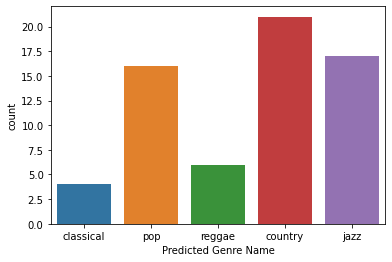

In [40]:
sns.countplot(data=all_prediction_df, x='Predicted Genre Name')

**Predicting the genre of the song by taking the mean value of the porbabilities of the genres along the column**

In [41]:
prediction_mean = all_prediction_df.iloc[:,:-2].apply(np.mean, axis=0)
prediction_mean

blues        0.002799
classical    0.083147
country      0.277864
disco        0.015341
hiphop       0.006064
jazz         0.249745
metal        0.009917
pop          0.215317
reggae       0.084911
rock         0.054895
dtype: float64

In [42]:
prediction_mean.index

Index(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal',
       'pop', 'reggae', 'rock'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

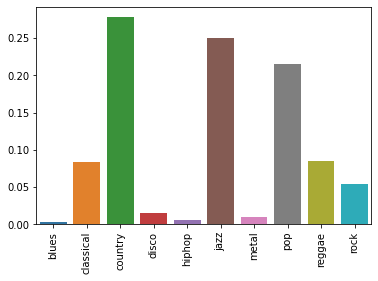

In [43]:
sns.barplot(prediction_mean.index, prediction_mean)
plt.xticks(rotation=90)

**Plotting the probabilitiy distribution of the predicted values of the genres of the song**

<BarContainer object of 10 artists>

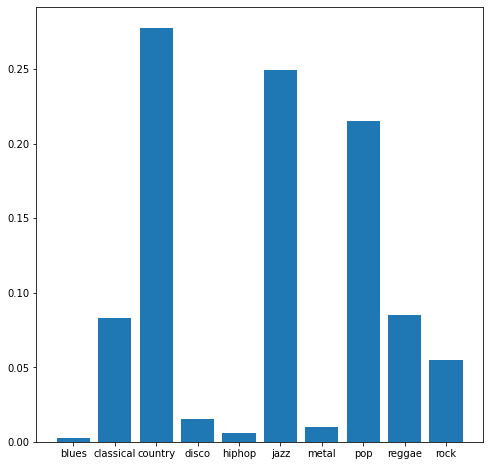

In [44]:
plt.figure(figsize=(8,8))
plt.bar(prediction_mean.index, prediction_mean,)

In [45]:
# type(prediction_mean)

In [46]:
all_prediction_df.iloc[:,:-2].apply(np.mean, axis=0).sum()

1.0000000691507012

In [47]:
all_prediction_df.iloc[:,:-2].apply(np.mean, axis=0).idxmax()

'country'

# Prediction Function Module

In [48]:
# num = 236/30
# num

In [49]:
# num = int(np.floor(num))
# num

In [50]:
# int(236/30)

In [51]:
# signal, sample_rate = librosa.load(song_path, sr=SAMPLE_RATE)
# song_length = int(librosa.get_duration(filename=song_path))

In [52]:
# discarded_song_length = (song_length % 30)

In [53]:
# song_length -= discarded_song_length
# song_length

In [54]:
# SAMPLES_PER_SONG = SAMPLE_RATE * song_length
# parts= song_length/30
# SAMPLES_PER_SEGMENT_30 = int(SAMPLES_PER_SONG/(parts))
# print(SAMPLES_PER_SEGMENT_30)

In [55]:
def predict_song(song_path):
    signal, sample_rate = librosa.load(song_path, sr=SAMPLE_RATE)
    song_length = int(librosa.get_duration(filename=song_path))
    
    if song_length > 30:
        discarded_song_length = (song_length % 30)
        song_length -= discarded_song_length
        # print(f"Song is greater than 30 seconds")
        SAMPLES_PER_SONG = SAMPLE_RATE * song_length
        parts= int(song_length/30)
        SAMPLES_PER_SEGMENT_30 = int(SAMPLES_PER_SONG/(parts))
        flag = 1
        # print(SAMPLES_PER_SEGMENT_30)

    elif song_length ==30:
        parts = 1
        flag = 0
    else:
        print("Too short, enter a song of length minimum 30 seconds")
        flag = 2

    single_file_df = pd.DataFrame()
    for i in range(0, parts):
        if flag ==1:
            # print(f'Song snipped: {i+1}')
            # calculate start and finish sample for current part
            start30 = SAMPLES_PER_SEGMENT_30  * i
            finish30= start30 + SAMPLES_PER_SEGMENT_30
            y = signal[start30:finish30]
        elif flag == 0:
            # print('Song is 30 seconds long so no need for slicing.')
            y = signal
            print()
        
        for segment in range(num_segments):
            # calculate start and finish sample for current segment
            start_sample = num_samples_per_segment * segment 
            finish_sample = start_sample + num_samples_per_segment

            #extract mfcc
            mfcc = librosa.feature.mfcc(y[start_sample:finish_sample], sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
            mfcc = mfcc.T
            # print(f'Shape of mfcc: {mfcc.shape}')
            # mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1],1)
            if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                segment_df = pd.DataFrame(data=mfcc,
                                        columns= headers,
                                                index = range(len(mfcc)))
                single_file_df = pd.concat([single_file_df, segment_df],
                                        axis=0,
                                        sort=False,
                                        ignore_index=True)


    if flag == 1:
      single_file_df = single_file_df.iloc[390: len(single_file_df) - 390] 
            
    song_values= []
    for i in range(0,single_file_df.shape[0],130):
        # print(i, i+130)
        # i+1
        # if i>=song_df2.shape[0]+130:
        #     break
        song_values.append(single_file_df.iloc[i:i+130,:])
        i+=1
        if i >=single_file_df.shape[0]+130:
            break

    predictions = []
    for x in range(len(song_values)):
        X_to_predict = np.expand_dims(song_values[x],0)
        X_to_predict = np.expand_dims(X_to_predict,3)
        # print(X_to_predict.shape)
        test = np.array(X_to_predict, dtype=np.float32)
        try:
            result = cnn_model.predict(test)
            predictions.append(result)
        except Exception as e:
            print(f'{e}')

    all_prediction_df = pd.DataFrame(columns=genres)
    for prediction in predictions:
        predict_row = pd.DataFrame(data=prediction, columns=genres)
        all_prediction_df = pd.concat([all_prediction_df, predict_row], ignore_index=True)
    print("")
    print(f"Predicted genre of the song: ", all_prediction_df.apply(np.mean, axis=0).idxmax())

    # Plotting the probability distribution of the song
    prediction_mean = all_prediction_df.apply(np.mean, axis=0)
    # sns.barplot(prediction_mean.index, prediction_mean)
    # plt.xticks(rotation=90)

    plt.figure(figsize=(8,8))
    plt.bar(prediction_mean.index, prediction_mean,)


In [56]:
# def predict_song(song_path):
#     signal, sample_rate = librosa.load(song_path, sr=SAMPLE_RATE)
#     song_length = int(librosa.get_duration(filename=song_path))
    
#     if song_length > 30:
#         # print(f"Song is greater than 30 seconds")
#         SAMPLES_PER_SONG = SAMPLE_RATE * song_length
#         parts= int(song_length/30)
#         SAMPLES_PER_SEGMENT_30 = int(SAMPLES_PER_SONG/(parts))
#         flag = 1

#     elif song_length ==30:
#         parts = 1
#         flag = 0
#     else:
#         print("Too short, enter a song of length minimum 30 seconds")
#         flag = 2

#     single_file_df = pd.DataFrame()
#     for i in range(0, parts):
#         if flag ==1:
#             # print(f'Song snipped: {i+1}')
#             # calculate start and finish sample for current part
#             start30 = SAMPLES_PER_SEGMENT_30  * i
#             finish30= start30 + SAMPLES_PER_SEGMENT_30
#             y = signal[start30:finish30]
#         elif flag == 0:
#             # print('Song is 30 seconds long so no need for slicing.')
#             y = signal
#             print()
        
#         for segment in range(num_segments):
#             # calculate start and finish sample for current segment
#             start_sample = num_samples_per_segment * segment 
#             finish_sample = start_sample + num_samples_per_segment

#             #extract mfcc
#             mfcc = librosa.feature.mfcc(y[start_sample:finish_sample], sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
#             mfcc = mfcc.T
#             # print(f'Shape of mfcc: {mfcc.shape}')
#             # mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1],1)
#             if len(mfcc) == expected_num_mfcc_vectors_per_segment:
#                 segment_df = pd.DataFrame(data=mfcc,
#                                         columns= headers,
#                                                 index = range(len(mfcc)))
#                 single_file_df = pd.concat([single_file_df, segment_df],
#                                         axis=0,
#                                         sort=False,
#                                         ignore_index=True)


#     if flag == 1:
#       single_file_df = single_file_df.iloc[390: len(single_file_df) - 390] 
            
#     song_values= []
#     for i in range(0,single_file_df.shape[0],130):
#         # print(i, i+130)
#         # i+1
#         # if i>=song_df2.shape[0]+130:
#         #     break
#         song_values.append(single_file_df.iloc[i:i+130,:])
#         i+=1
#         if i >=single_file_df.shape[0]+130:
#             break

#     predictions = []
#     for x in range(len(song_values)):
#         X_to_predict = np.expand_dims(song_values[x],0)
#         X_to_predict = np.expand_dims(X_to_predict,3)
#         # print(X_to_predict.shape)
#         test = np.array(X_to_predict, dtype=np.float32)
#         try:
#             result = cnn_model.predict(test)
#             predictions.append(result)
#         except Exception as e:
#             print(f'{e}')

#     all_prediction_df = pd.DataFrame(columns=genres)
#     for prediction in predictions:
#         predict_row = pd.DataFrame(data=prediction, columns=genres)
#         all_prediction_df = pd.concat([all_prediction_df, predict_row], ignore_index=True)
#     print("")
#     print(f"Predicted genre of the song: ", all_prediction_df.apply(np.mean, axis=0).idxmax())

#     # Plotting the probability distribution of the song
#     prediction_mean = all_prediction_df.apply(np.mean, axis=0)
#     sns.barplot(prediction_mean.index, prediction_mean)
#     plt.xticks(rotation=90)

#     plt.figure(figsize=(8,8))
#     plt.bar(prediction_mean.index, prediction_mean,)

#     all_prediction_df['Predicted_Genre'] = all_prediction_df.apply(np.argmax,axis='columns')
#     print(all_prediction_df['Predicted_Genre'].value_counts())


# Testing prediction on different songs

**Test 1 - Teen Spirits by Nirvana (Rock)**


Predicted genre of the song:  rock


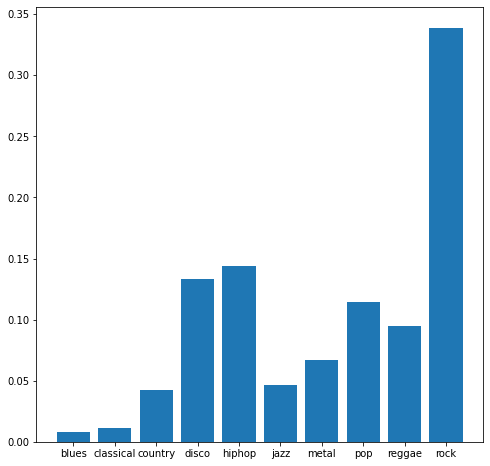

In [57]:
song_path = os.getcwd()+'/drive/MyDrive/Sub_Data/Songs/nirvana_teen_spirits.wav'
predict_song(song_path)

**Test 2 - Love Story by Taylor Swift (Genre: Pop/Country)**

In [58]:
song_path = os.getcwd()+'/drive/MyDrive/Sub_Data/Songs/love_story.wav'


Predicted genre of the song:  country


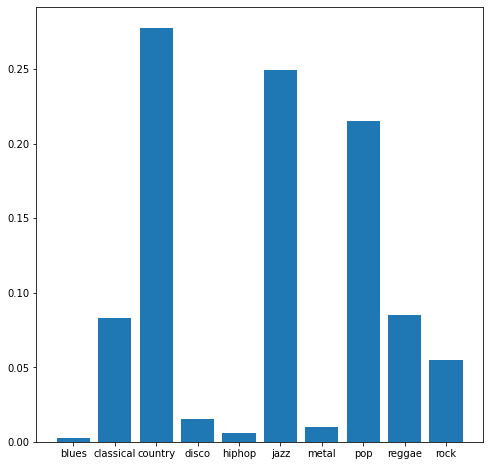

In [59]:
predict_song(song_path)

**Test 3 - Girls Like You by Maroon 5 (Pop)**


Predicted genre of the song:  pop


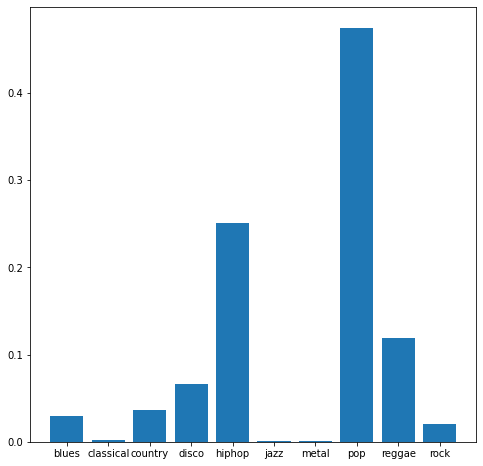

In [60]:
song_path2 = os.getcwd()+'/drive/MyDrive/Sub_Data/Songs/girls_like_you.wav'
predict_song(song_path2)

**Test 4 - Coastal Ruminations I by Ben Nestor (Classical)**

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



Predicted genre of the song:  classical


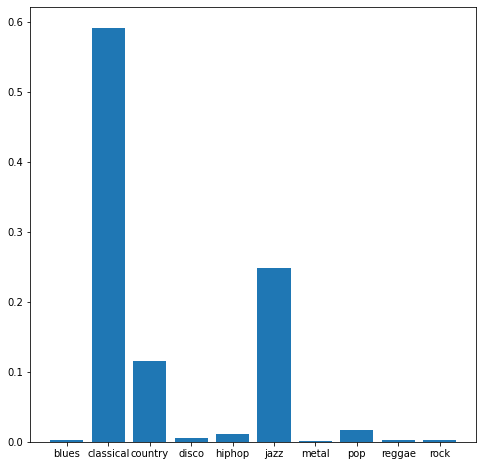

In [61]:
song_path2 = os.getcwd()+'/drive/MyDrive/Sub_Data/Songs/Ben Nestor - Coastal Ruminations I_Classical.mp3'
predict_song(song_path2)

# Testing on GTZAN Dataset saved previously for model prediction




Predicted genre of the song:  blues


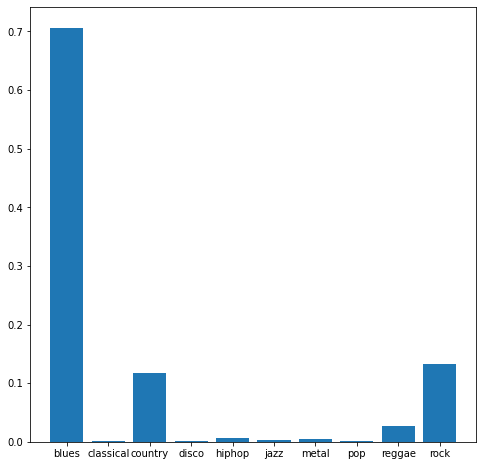

In [62]:
song_path2 = os.getcwd()+'/drive/MyDrive/Sub_Data/Audio/Blues/blues.00095.wav'
predict_song(song_path2)



Predicted genre of the song:  country


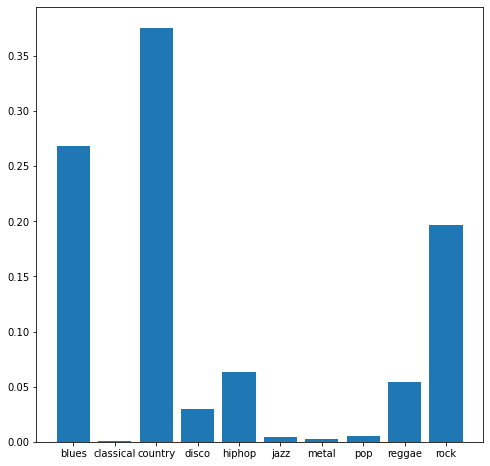

In [67]:
song_path2 = os.getcwd()+'/drive/MyDrive/Sub_Data/Audio/Blues/blues.00097.wav'
predict_song(song_path2)



Predicted genre of the song:  metal


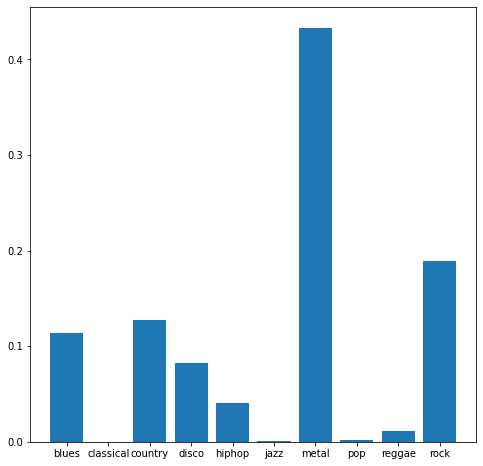

In [68]:
song_path2 = os.getcwd()+'/drive/MyDrive/Sub_Data/Audio/Blues/blues.00098.wav'
predict_song(song_path2)



Predicted genre of the song:  classical


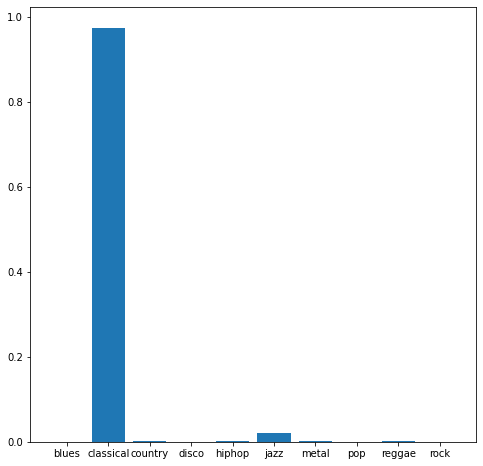

In [70]:
song_path2 = os.getcwd()+'/drive/MyDrive/Sub_Data/Audio/Classical/classical.00095.wav'
predict_song(song_path2)



Predicted genre of the song:  classical


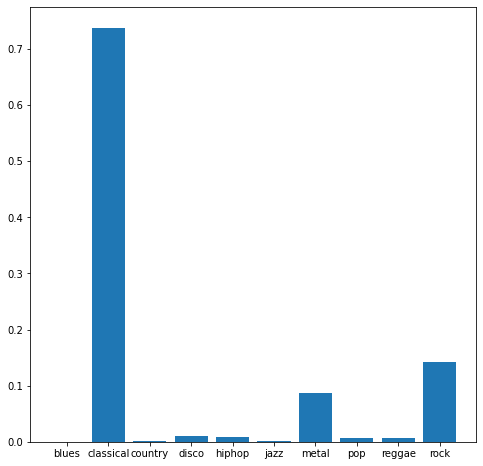

In [71]:
song_path2 = os.getcwd()+'/drive/MyDrive/Sub_Data/Audio/Classical/classical.00096.wav'
predict_song(song_path2)



Predicted genre of the song:  classical


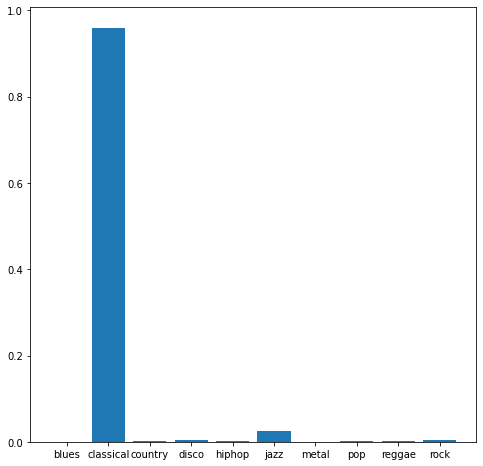

In [72]:
song_path2 = os.getcwd()+'/drive/MyDrive/Sub_Data/Audio/Classical/classical.00097.wav'
predict_song(song_path2)



Predicted genre of the song:  country


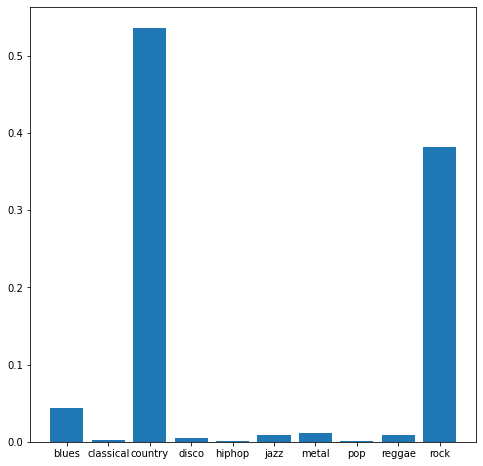

In [73]:
song_path2 = os.getcwd()+'/drive/MyDrive/Sub_Data/Audio/Country/country.00095.wav'
predict_song(song_path2)



Predicted genre of the song:  country


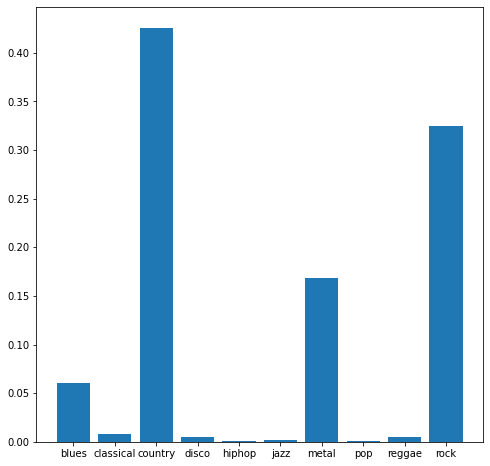

In [74]:
song_path2 = os.getcwd()+'/drive/MyDrive/Sub_Data/Audio/Country/country.00096.wav'
predict_song(song_path2)



Predicted genre of the song:  country


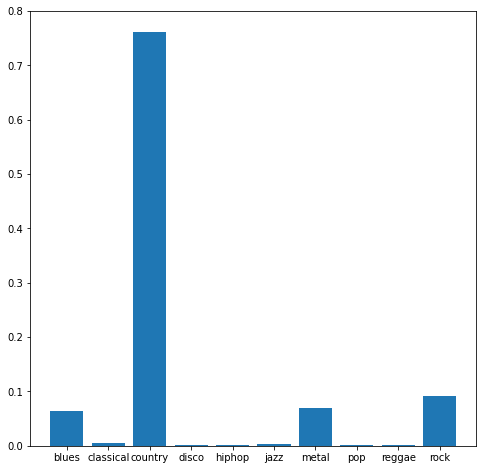

In [75]:
song_path2 = os.getcwd()+'/drive/MyDrive/Sub_Data/Audio/Country/country.00097.wav'
predict_song(song_path2)



Predicted genre of the song:  blues


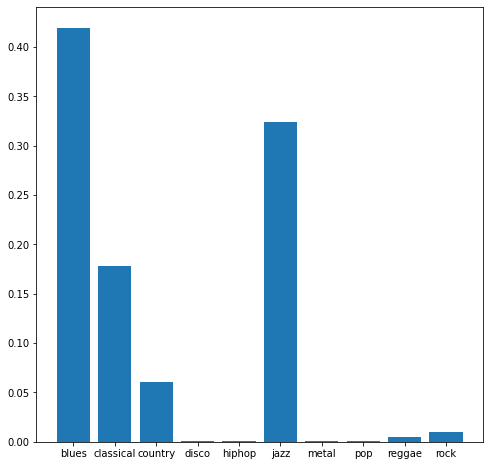

In [76]:
song_path2 = os.getcwd()+'/drive/MyDrive/Sub_Data/Audio/Jazz/jazz.00097.wav'
predict_song(song_path2)



Predicted genre of the song:  jazz


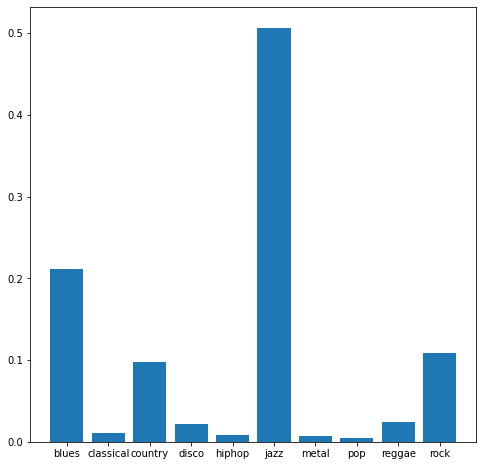

In [77]:
song_path2 = os.getcwd()+'/drive/MyDrive/Sub_Data/Audio/Jazz/jazz.00095.wav'
predict_song(song_path2)



Predicted genre of the song:  metal


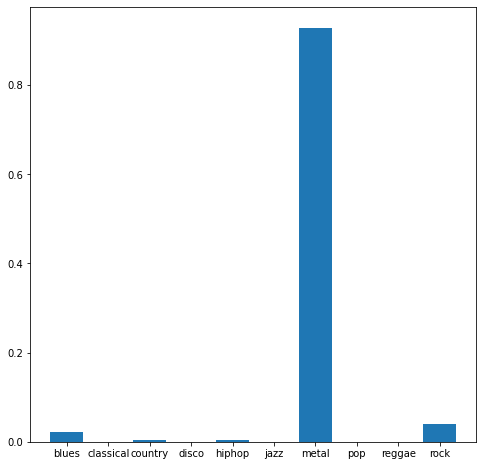

In [78]:
song_path2 = os.getcwd()+'/drive/MyDrive/Sub_Data/Audio/Metal/metal.00097.wav'
predict_song(song_path2)



Predicted genre of the song:  metal


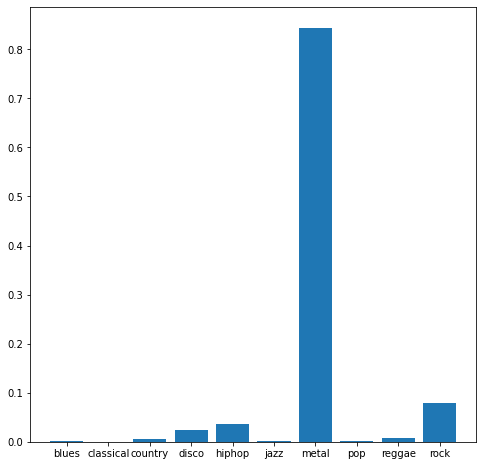

In [79]:
song_path2 = os.getcwd()+'/drive/MyDrive/Sub_Data/Audio/Metal/metal.00095.wav'
predict_song(song_path2)